In [ ]:
#https://towardsdatascience.com/gps-trajectory-clustering-with-python-9b0d35660156
#https://taginfo.openstreetmap.org/tags/type=public_transport#overview

# distancias points

In [ ]:
# PARA OCONVERTIR RECORRIDOS GEOMS EN GRAPHS
#https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils_graph.graph_from_gdfs

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import osmnx as ox 
from shapely.geometry import LineString
import geopandas as gpd
from osmnx import downloader,utils_geo,graph
import pickle
import networkx as nx
from osmnx._errors import EmptyOverpassResponse
import osmnx as ox
from osmnx import utils_graph, distance, downloader,graph


In [2]:
# del original _create_graph
def create_branch_graph(response_json_branch, retain_all=False, bidirectional=True):
    """
    Create a networkx MultiDiGraph from Overpass API responses.
    Adds length attributes in meters (great-circle distance between endpoints)
    to all of the graph's (pre-simplified, straight-line) edges via the
    `distance.add_edge_lengths` function.
    Parameters
    ----------
    response_json_branch : dict
        dicts of JSON response for a route branch from the Overpass API
    retain_all : bool
        if True, return the entire graph even if it is not connected.
        otherwise, retain only the largest weakly connected component.
    bidirectional : bool
        if True, create bi-directional edges for one-way streets
    Returns
    -------
    G : networkx.MultiDiGraph
    """
    print("Creating graph from downloaded OSM data...")

    # create the graph as a MultiDiGraph and set its meta-attributes
    metadata = {
        "created_date": ox.utils.ts(),
        "crs": "epsg:4326",
        "line_name": response_json_branch['tags']['name'],
        "headway":response_json_branch['tags']['to']
    }
    G = nx.MultiDiGraph(**metadata)

    # query nodes and ways to get xy coords
    nodes = {}
    paths = {}
    nodes_temp, paths_temp = query_branch_nodes_paths(response_json_branch)
    nodes.update(nodes_temp)
    paths.update(paths_temp)

    # add each osm node to the graph
    for node, data in nodes.items():
        G.add_node(node, **data)

    # add each osm way (ie, a path of edges) to the graph
    graph._add_paths(G, paths.values(), bidirectional)

    # retain only the largest connected component if retain_all is False
    if not retain_all:
        G = utils_graph.get_largest_component(G)

    print(f"Created graph with {len(G)} nodes and {len(G.edges)} edges")

    # add length (great-circle distance between nodes) attribute to each edge
    if len(G.edges) > 0:
        G = distance.add_edge_lengths(G)

    return G
    
def query_branch_nodes_paths(response_json_branch):
    """
    Create a set of nodes and paths belonging to a relation in Osmnx schema
    (the one _parse_nodes_paths outpus) from Overpass API responses.  
    Parameters
    ----------
    response_json_branch : dict
        dicts of JSON response for a route branch from the Overpass API
    Returns
    -------
    nodes, paths : tuple of dicts
        dicts' keys = osmid and values = dict of attributes
    """ 

    overpass_settings = downloader._make_overpass_settings()

    # get path ids
    path_ids = [m['ref'] if m['type']=='way'else None for m in response_json_branch['members']]
    path_ids = list(filter(lambda item: item is not None, path_ids))
    path_ids = ','.join(map(str,path_ids))

    query_str = f"{overpass_settings};(way(id:{path_ids});>;);out;"
    response_json = downloader.overpass_request(data={"data": query_str})

    nodes, paths = graph._parse_nodes_paths(response_json)
    return nodes, paths

def query_public_transport_box(north,south,east,west):
    """
    Queries OSMN public transportation relations
    from a boungind box
    
    Parameters
    ----------
    north : float
        northern latitude of bounding box
    south : float
        southern latitude of bounding box
    east : float
        eastern longitude of bounding box
    west : float
        western longitude of bounding box

    Returns
    -------
    nodes, paths : tuple of dicts
        dicts' keys = osmid and values = dict of attributes
    """ 

    bbox = (str(south) + "," +
            str(west) + "," +
            str(north) + "," +
            str(east))
    
    tags = '["public_transport:version" = "2"]'

    query_str = """
        [out:json];
        (
        relation%s(%s);
        relation[type=route_master](br.routes);
        way(r.routes);
        node(w);
        ( .routes;.masters;._; );
        );out body;""" % (tags, bbox)
    response_json_branches = ox.downloader.overpass_request(data={'data':query_str})
        # make sure we got data back from the server request(s)
    if not 'elements' in response_json_branches:  # pragma: no cover
        raise EmptyOverpassResponse("There are no data elements in the response JSON")
    else:
        response_json_branches = response_json_branches['elements']
    return response_json_branches

In [3]:
# http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000
# carabobo y rivadavia
s,w,n,e =  -34.628335,-58.460591,-34.624062,-58.450291 

# linea 47
s,w,n,e = -34.626048,-58.530478,-34.621903,-58.520179 

In [4]:
response_json_branches = query_public_transport_box(s,w,n,e)

In [20]:
routes_of_interest = []
route_interest_name = 'Línea 47'
for i in response_json_branches:
    try:
        print(i['tags']['name'])
        if route_interest_name in i['tags']['name']:
            routes_of_interest.append(i)
    except:
        print('ERROR')
        print(i['tags'])

Línea 26: Barrio Rivadavia → Retiro
Línea 26: Retiro → Barrio Rivadavia
Línea 5: Retiro → Piedrabuena
Línea 126: Cementerio de Villegas → Retiro
Línea 44: Puente Alsina → Barrancas de Belgrano
Línea 44: Barrancas de Belgrano → Puente Alsina
Línea 126: Retiro → Cementerio de Villegas
Línea 134: Dock Sud → Estación Villa Devoto
Línea 134: Estación Villa Devoto → Dock Sud
Línea Roca: Temperley → Haedo
Línea Belgrano Sur: Doctor Antonio Sáenz → Marinos del Crucero General Belgrano
Línea Roca: Bosques → Gutiérrez
Buenos Aires Bus
Línea 132: Cementerio de Flores → x Carabobo → Terminal de Ómnibus
Línea Belgrano Sur: Kilómetro 12 → Libertad
Línea Belgrano Sur: González Catán → Doctor Antonio Sáenz
Ferrocarril Roca: Constitución → Bahía Blanca
Ferrocarril Roca: Constitución → Mar del Plata
Línea Roca: Temperley → General Alvear
Ferrocarril Sarmiento: Bragado → Once
Línea 132: Cementerio de Flores → Flores → Terminal de Ómnibus
Línea 106: Liniers → Retiro
Línea 106: Retiro → Liniers
Línea 5: Pi

In [22]:
len(routes_of_interest)

4

In [26]:
#identify route
#response_json_branch = response_json_branches[6]
response_json_branch = routes_of_interest[0]
response_json_branch['tags']

{'colour': 'red',
 'fee': 'yes',
 'from': 'Lacroze',
 'name': 'Línea 47: Lacroze → x Camarones → Autódromo',
 'network': 'Nacional',
 'operator': 'Línea de Micro Ómnibus 47 S.A.',
 'payment:sube': 'only',
 'public_transport:version': '2',
 'ref': '47C',
 'reservation': 'no',
 'route': 'bus',
 'scope': 'urban',
 'to': 'Autódromo',
 'type': 'route',
 'via': 'Camarones',
 'wheelchair': 'yes'}

In [27]:
G = create_branch_graph(response_json_branch)

Creating graph from downloaded OSM data...
Created graph with 737 nodes and 1472 edges


In [40]:
gdf_p,gdf_l = ox.graph_to_gdfs(G)

In [42]:
gdf_l.explore()

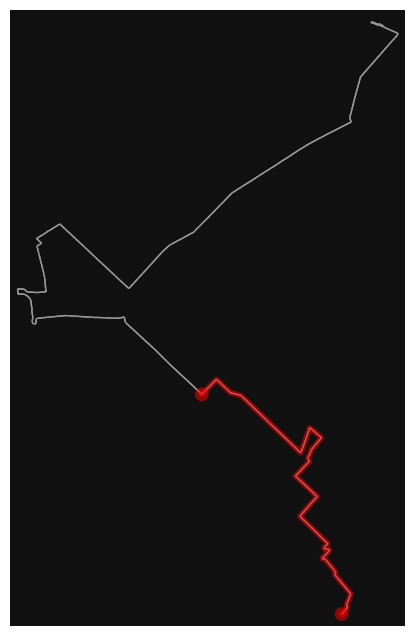

8156

In [28]:
o_y,o_x= -34.591003, -58.391161
d_y,d_x= -34.627839, -58.477069 

o_y,o_x= -34.667104,-58.492852
d_y,d_x= -34.607069,-58.488142 

orig = ox.distance.nearest_nodes(G, X=o_x, Y=o_y)
dest = ox.distance.nearest_nodes(G, X=d_x, Y=d_x)  

# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))
